# Part 1: How accurate are moneylines?

"Odds and lines aren't supposed to be about being perfect, they're supposed to invite action on both sides for the sportsbooks to make a profit."

Given that odds can shift dramatically depending on the public's bets, can we spot opportunities where the public (and therefore the line) doesn't match up with "actual" odds?

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from operator import attrgetter

%matplotlib inline
sns.set_style('whitegrid')

# Import datasets
df_nba_lines_17 = pd.read_csv('./SBRscraper/SBR_NBA_Lines_2017-18.csv')
df_nba_lines_18 = pd.read_csv('./SBRscraper/SBR_NBA_Lines_2018-19.csv')
df_nba_lines_19 = pd.read_csv('./SBRscraper/SBR_NBA_Lines_2019-20.csv')

# Combine all into single dataframe
df_nba_lines = pd.concat([df_nba_lines_17, df_nba_lines_18, df_nba_lines_19], ignore_index=True)

In [2]:
# Function that calculates win probability from moneyline
def ml_to_win_prob(ml):
    if ml < 0:
        prob = -ml / (-ml + 100)
    else:
        prob = 100 / (ml + 100)

    return prob

In [3]:
# TODO: throw out All Star games

# Data wrangling: add new columns for W/L outcomes and win probabilities
df_generator = df_nba_lines.iterrows()
for (i, row1), (j, row2) in zip(df_generator, df_generator):
    # Determine winner of each game and insert values in new column
    if row1['score'] < row2['score']:
        df_nba_lines.at[i, 'outcome'] = 'L'
        df_nba_lines.at[j, 'outcome'] = 'W'
    elif row1['score'] > row2['score']:
        df_nba_lines.at[i, 'outcome'] = 'W'
        df_nba_lines.at[j, 'outcome'] = 'L'

    # Calculate implied win probabilities for each team
    row1_win_prob = ml_to_win_prob(row1['ml_PIN'])
    row2_win_prob = ml_to_win_prob(row2['ml_PIN'])
    df_nba_lines.at[i, 'win_prob_PIN'] = row1_win_prob
    df_nba_lines.at[j, 'win_prob_PIN'] = row2_win_prob

    # Calculate NORMALIZED win probabilities for each team
    prob_sum = row1_win_prob + row2_win_prob
    df_nba_lines.at[i, 'win_prob_norm_PIN'] = row1_win_prob / prob_sum
    df_nba_lines.at[j, 'win_prob_norm_PIN'] = row2_win_prob / prob_sum

In [4]:
### #1: Bucket games by ML and compare to actual win percentages. Are the ML actually predictive of final results?

# Plot histogram
#df_nba_lines.hist('ml_PIN', bins=50);

# Place outcomes into bins based upon their pregame implied win probabilities
bins = 30
df_pin = df_nba_lines[['key', 'date', 'ml_time', 'team', 'opp_team', 'score', 'ml_PIN', 'outcome', 'win_prob_PIN', 'win_prob_norm_PIN']]
df_pin['bin'] = pd.cut(df_pin['win_prob_norm_PIN'], bins=bins)

# df_pin['bin_left'] = df_pin['bin'].map(attrgetter('left'))
# df_pin['bin_right'] = df_pin['bin'].map(attrgetter('right'))
# df_pin['bin'] = df_pin['bin'].astype(str)

# Compare bins with actual win rates
outcomes = df_pin.groupby(['bin', 'outcome']).size()

# Group by "bin" and calculate W/L percentage for each bin
win_prob = outcomes.groupby(level=0).apply(lambda x: x / float(x.sum()))

# Convert to df
# df_outcomes = outcomes.reset_index(name='outcomes')
df_win_prob = win_prob.reset_index(name='win_rate')

# Add column for bin interval midpoint
df_win_prob['bin_mid'] = df_win_prob['bin'].map(attrgetter('mid')).astype(float)

# Filter only for win rate (remove loss rate and unneeded columns)
df_win_prob = df_win_prob[df_win_prob['outcome'] == 'W'][['bin', 'bin_mid', 'win_rate']]

# Calculate residuals (actual minus hypothetical)
df_win_prob['residual'] = df_win_prob['win_rate'] - df_win_prob['bin_mid']

# TODO: count for each bin
# x = outcomes.groupby(level=0).apply(lambda x: x.sum())
# y = outcomes.groupby(level=0).apply(lambda x: x / float(x.sum()))
# pd.concat([x, y], axis=1)

# Nicely formatted HTML table
df_win_prob.style.format({
    'bin_mid': '{:,.2%}'.format,
    'win_rate': '{:,.2%}'.format,
    'residual': '{:,.2%}'.format
})


,bin,bin_mid,win_rate,residual
1,"(0.0439, 0.0751]",5.95%,5.00%,-0.95%
3,"(0.0751, 0.105]",9.00%,11.63%,2.62%
5,"(0.105, 0.136]",12.05%,11.56%,-0.49%
7,"(0.136, 0.166]",15.10%,16.25%,1.15%
9,"(0.166, 0.197]",18.15%,24.56%,6.41%
11,"(0.197, 0.227]",21.20%,21.08%,-0.12%
13,"(0.227, 0.257]",24.20%,20.98%,-3.22%
15,"(0.257, 0.288]",27.25%,27.43%,0.18%
17,"(0.288, 0.318]",30.30%,29.75%,-0.55%
19,"(0.318, 0.348]",33.30%,30.19%,-3.11%


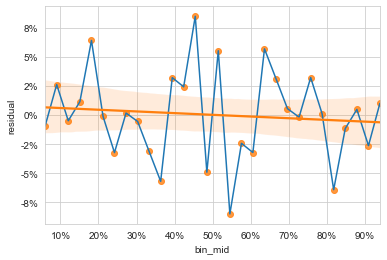

In [5]:
# Plot residuals
ax = sns.lineplot(x='bin_mid', y='residual', data=df_win_prob);
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set(xlabel='Win Probability', ylabel='Residual');

sns.regplot(x='bin_mid', y='residual', data=df_win_prob, fit_reg=True);

# Part 2: Betting on heavy favorites or underdogs

What happens if you only bet on heavy underdogs? Is there a threshold where a bet becomes a likely winner?


In [6]:
# Function that simulates a betting strategy
def simulate_bets():
    pass